# Transfer Learning Model with CIFAR-10 Dataset


In [1]:
import torch

In [2]:
import torchvision
from torchvision import transforms,datasets
import torch.utils.data.dataloader
from torch.utils.data import random_split


## Preparing Data

Defining the Data Transform Operation

In [3]:
data_transform = transforms.Compose([
	transforms.RandomHorizontalFlip(),
	transforms.Resize((224,224)),
	transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.CIFAR10(
    root='CIFAR10',
    train=True,
    download=True,
    transform=data_transform
    )

100%|██████████| 170498071/170498071 [00:02<00:00, 59883189.82it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10


In [5]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [6]:
class_names = dataset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Each Image is of the size 32x32 pixels

In [7]:
dataset[0][0].shape,dataset[0][1]

(torch.Size([3, 224, 224]), 6)

Divide the dataset into Training And Testing

In [8]:
TEST_TRAIN_SPLIT = 0.2
test_size = int(TEST_TRAIN_SPLIT * len(dataset))
train_size = len(dataset) - test_size
random_seed = 4
torch.manual_seed(random_seed)
train_ds, test_ds = random_split(dataset, [train_size, test_size])

In [9]:
len(train_ds),len(test_ds)

(40000, 10000)

### Visualizing

In [10]:
from matplotlib import pyplot as plt
import random

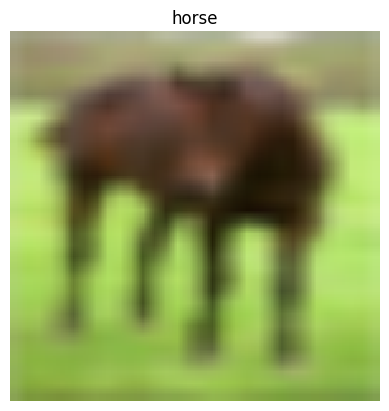

In [11]:
# random.seed(1212)
idx = random.randint(0,len(dataset))
plt.imshow(dataset[idx][0].permute(1,2,0), interpolation='nearest') # permute() will change shape of image to suit matplotlib imshow function (RGBC)
plt.title(class_names[dataset[idx][1]])
plt.axis('off')
plt.show()

### Making DataLoaders

In [12]:
from torch.utils.data import DataLoader
import os

In [13]:
os.cpu_count()

2

In [14]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

In [15]:
train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_ds,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

In [16]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a6ece1c5270>,
 <torch.utils.data.dataloader.DataLoader at 0x7a6ece1c55d0>)

Damm... this took too long

In [17]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


In [18]:
type(data_transform)

torchvision.transforms.transforms.Compose

### Creating Model using ResNet50

In [19]:
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

ResNet50 has 2048 output features for a next Fully Connected Layer

In [21]:
resnet50().fc.in_features

2048

Defining Model Class

In [22]:
class TF_Model_v0(nn.Module):
    def __init__(self, hidden_units=256):
        super().__init__()
        self.tf_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        for param in self.tf_model.parameters():
            param.requires_grad = False # Weights freeze
        self.fc = nn.Sequential(
            nn.Linear(1000,hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,10)
		).to(device)
    def forward(self,X):
        x = self.tf_model(X)
        x = self.fc(x)
        return x

In [23]:
torch.manual_seed(42)


In [28]:
# Loading Saved Model

# Instantiate a new instance of our model
model0 = TF_Model_v0().to(device)

# Load the state_dict, ensuring the tensors are mapped to the CPU if they were saved on a GPU
model0.load_state_dict(torch.load(f='./10_epoch_TF_Model_v0.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
from torch.optim import Adam

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model0.parameters())

Make One Forward Propogation

In [31]:
next(iter(train_dataloader))[0].size()

torch.Size([16, 3, 224, 224])

In [32]:
single_img = next(iter(train_dataloader))[0][0].unsqueeze(dim=0)
single_img.shape
label = next(iter(train_dataloader))[1][0]
single_img.shape, label.shape

(torch.Size([1, 3, 224, 224]), torch.Size([]))

In [33]:
model0.eval()
with torch.inference_mode():
    pred = model0(single_img.to(device))
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label}")

Output logits:
tensor([[-2.7650, -4.9961, -0.8654, -1.6770, -4.6757, -1.4962, -1.1218, -4.8613,
         -1.4817, -4.4047]])

Output prediction probabilities:
tensor([[0.0424, 0.0046, 0.2837, 0.1260, 0.0063, 0.1510, 0.2195, 0.0052, 0.1532,
         0.0082]])

Output prediction label:
tensor([2])

Actual label:
3


In [34]:
!pip install torchinfo

In [35]:
import torchinfo

from torchinfo import summary
summary(model0, input_size=[1, 3, 128, 128]) # do a test pass through of an example input size

Layer (type:depth-idx)                        Output Shape              Param #
TF_Model_v0                                   [1, 10]                   --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           --
│    └─Sequential: 2-5                        [1, 256, 32, 32]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 32, 32]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 32, 32]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 32, 32]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 16, 16]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 16, 16]       

## Train Model

In [36]:

def training(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer):
    model.train()   # Put model in train mode
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader) * 100
    return train_loss, train_acc

In [37]:
def testing(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module
            ):
    model.eval()
    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device) #sending data to target device, otherwise getting error

            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss+=loss

            y_pred_class = torch.argmax(y_pred,dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(y_pred)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader) * 100
    return test_loss, test_acc

In [38]:
from tqdm.auto import tqdm

In [ ]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [ ]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training(model=model0,
                                     dataloader=train_dataloader,
                                     loss_fn=criterion,
                                     optimizer=optimizer)
    test_loss, test_acc = testing(model=model0,
                                  dataloader=test_dataloader,
                                  loss_fn=criterion,
                                  optimizer=optimizer)
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Validation loss: {test_loss:.4f} | Validation acc: {test_acc:.2f}%")

    test_losses.append(test_loss)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

In [ ]:
# from pathlib import Path

# # 1. Create models directory
# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)

# # 2. Create model save path
# MODEL_NAME = "10_epoch_TF_Model_v0.pth"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# # 3. Save the model state dict
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model0.state_dict(), # only saving the state_dict() only saves the models learned parameters
#            f=MODEL_SAVE_PATH)

In [ ]:
for i in range(len(test_losses)):
    if (str(type(test_losses[i]))  != "<class 'float'>"):
        print(type(test_losses[i]))
        test_losses[i] = test_losses[i].cpu().item()

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()
plt.plot(train_accs, label="train_acc")
plt.plot(test_accs, label="test_acc")
plt.legend()
plt.savefig('10epoch_model0_tf.png')

## Visalizing Predictions

In [39]:
def visualize_predictions(model: torch.nn.Module, test_dataset, device: torch.device = device, seed=10, n=4):
    random.seed(seed)
    for i in range(n):
        idx = random.randint(0,len(test_dataloader))
        model.eval()
        with torch.inference_mode():
            X, y = test_dataset[idx]
            X = X.unsqueeze(0).to(device)
            # y = y.to(device)
            y_pred = model(X)
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        plt.imshow(X.cpu().squeeze().permute(1, 2, 0), interpolation='nearest')
        plt.title(f"Actual: {class_names[y]} | Predicted: {class_names[y_pred_class]}")
        plt.axis(False)
        plt.show()


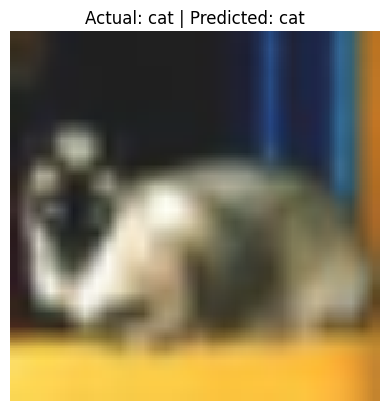

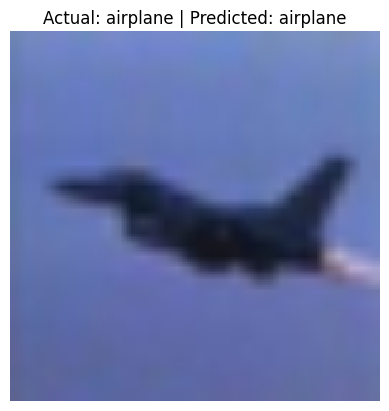

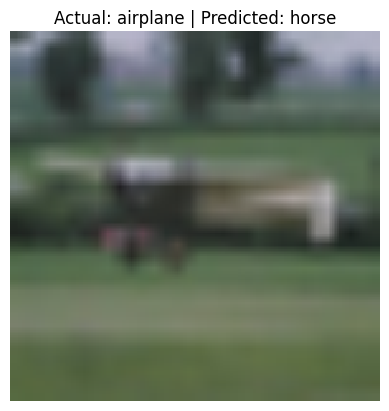

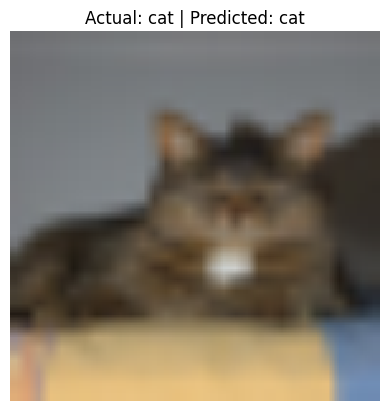

In [40]:
visualize_predictions(model=model0, test_dataset = test_ds)

## Testing

In [42]:
model0.eval()

TF_Model_v0(
  (tf_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
test_loss, test_acc = testing(model=model0,
                                dataloader=test_dataloader,
                                loss_fn=criterion,
                                optimizer=optimizer)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")



Model gives around 80% accuracy